In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Dataset
- Merge two datasets

In [2]:
# import two datasets
data = pd.read_csv('data science_fraud.csv')
country = pd.read_excel('IpAddress_to_Country.xlsx')

In [3]:
# create a new column which contains the index of the matching IP interval from country
data['x'] = data.ip_address.apply(lambda x: country.query('lower_bound_ip_address <= @x <= upper_bound_ip_address')
                      .index.values).apply(lambda x: x[0] if len(x) else -1)

# merge two datasets
data2 = pd.merge(data,country,left_on='x',right_index=True,how='left').drop(['x','lower_bound_ip_address','upper_bound_ip_address'],1)

In [4]:
data2.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


# Exploratory Data Analysis

In [5]:
data2.shape

(120000, 13)

- country column has nearly 15% missing data. It is because some of the ip_address contain a dot which maybe a typo and some of the ip_address out of the ip_address range in the Country dataset. It is better to confirm witht the data provider. But in this case, I will just replace them later.

In [6]:
data2.isnull().mean()

Unnamed: 0        0.00000
user_id           0.00000
signup_time       0.00000
purchase_time     0.00000
purchase_value    0.00000
device_id         0.00000
source            0.00000
browser           0.00000
sex               0.00000
age               0.00000
ip_address        0.00000
class             0.00000
country           0.14515
dtype: float64

- As we can see in the plot below, it only contains 9% positive cases in this dataset, so this is an imbalanced dataset. We can try some resampling methods when building models

0    108735
1     11265
Name: class, dtype: int64


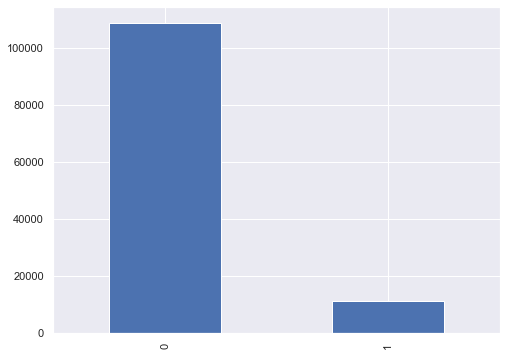

In [7]:
# imbalanced dataset
print (data2['class'].value_counts())
sns.set(rc={'figure.figsize':(8,6)})
data2['class'].value_counts().plot.bar()

## Explore some features

*** Signup_time & Purchase_time

- Extract the month, day and hour information, and create some new columns

In [8]:
#######create new columns
#signup_time
data2['signup_time'] = pd.to_datetime(data2['signup_time'], format='%m/%d/%Y %H:%M')
data2['signup_month']=pd.DatetimeIndex(data2['signup_time']).month
data2['signup_dayofweek']=pd.DatetimeIndex(data2['signup_time']).dayofweek
data2['signup_hour']=pd.DatetimeIndex(data2['signup_time']).hour

#purchase_time
data2['purchase_time'] = pd.to_datetime(data2['purchase_time'], format='%m/%d/%Y %H:%M')
data2['purchase_month']=pd.DatetimeIndex(data2['purchase_time']).month
data2['purchase_dayofweek']=pd.DatetimeIndex(data2['purchase_time']).dayofweek
data2['purchase_hour']=pd.DatetimeIndex(data2['purchase_time']).hour

# gap - month
data2['gap_month']=data2['purchase_month']-data2['signup_month']

- Both the signup and purchase months for most fraudulent transactions happended in January
- All transactions happened within 4 months after signup, same for fraudulent transactions. But most of the fraudulent transactions happened within the same month when signup

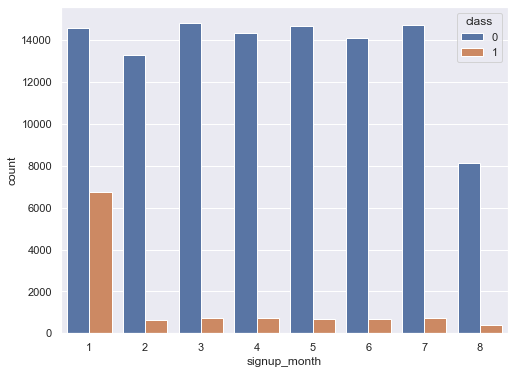

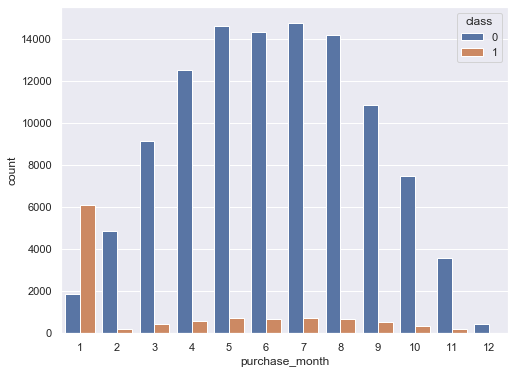

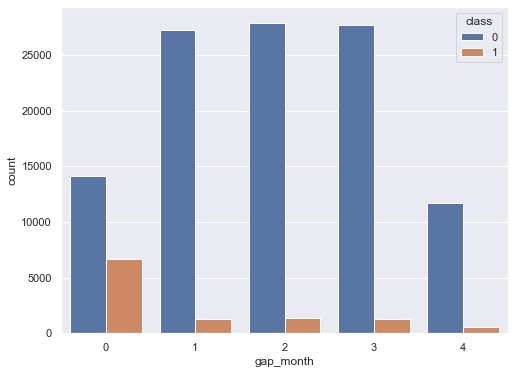

In [9]:
time = ['signup_month','purchase_month','gap_month']
for i in time:
    sns.countplot(x=i, hue="class",data=data2)
    plt.show()

- If we dig into the time feature, we can know most of the fraudulent transactions happened on the same day, the same hour and the same minute of signup. In other words, there are many fraudulent transactions which the signup and purchase happened at the same time

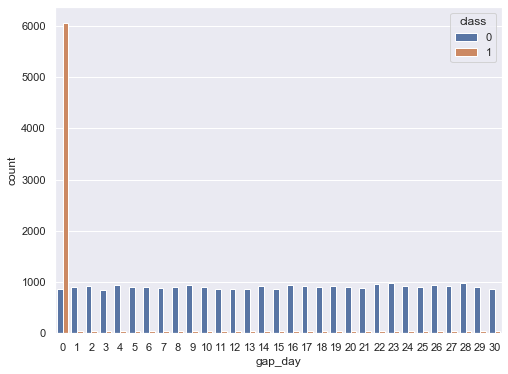

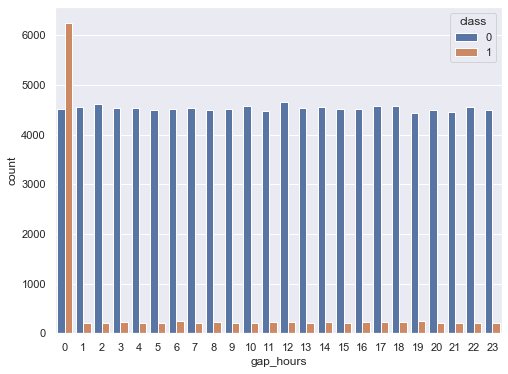

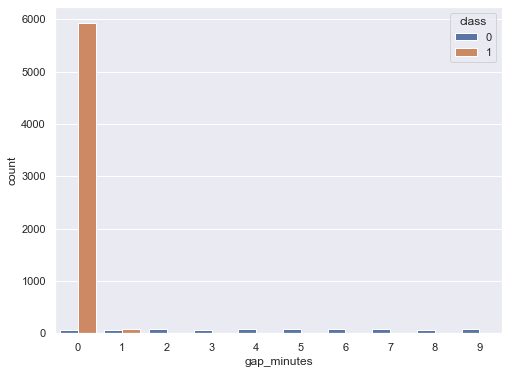

In [10]:
# gap - day
data2['gap_date']=data2['purchase_time']-data2['signup_time']
data2['gap_day']=data2['gap_date'].dt.days
sns.countplot(x='gap_day', hue="class",data=data2[data2['gap_day']<31])
plt.show()

#gap - hours
data2['gap_hours']=data2['gap_date'].dt.seconds//3600
sns.countplot(x='gap_hours', hue="class",data=data2[data2['gap_hours']<24])
plt.show()

#gap - minutes
data2['gap_minutes']=data2['gap_date'].dt.seconds//60
sns.countplot(x='gap_minutes', hue="class",data=data2[data2['gap_minutes']<10])
plt.show()

- 9.4% of transactions are fraudulent in our dataset
- 50% of fraudulent transactions happend at the same minutes of signup

In [11]:
# add percentage in the plot
def plot_percentage(ax, data):
    total = float(len(data))
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha = 'center')
    return plt.show()    

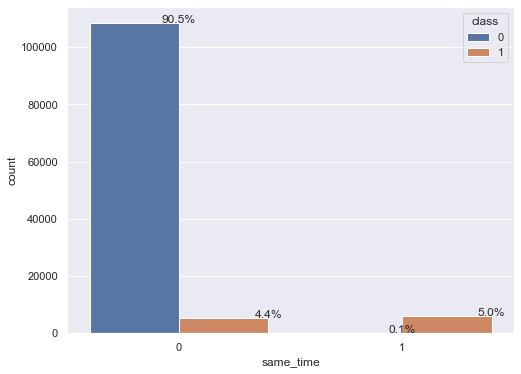

In [12]:
data2['same_time']=np.where(data2['gap_minutes']<2,1,0) 
#plot
ax = sns.countplot(x='same_time', hue="class",data=data2)
plot_percentage(ax, data2)

*** purchase_value

- there are some outliers of purchase value
- the purchase_value for fraudulent transactions ranges from 9 dollar to 111 dollar
- most purchase_value for the fraudulent transactions are between 20 dollar to 40 dollar 

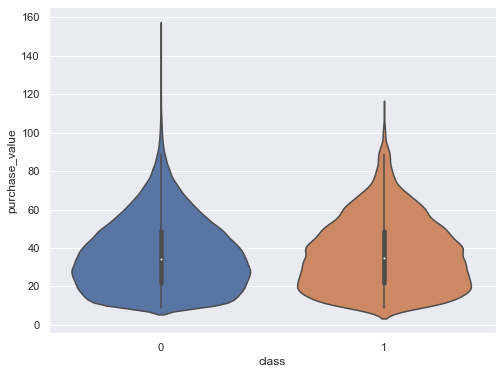

In [13]:
sns.violinplot(x='class',y='purchase_value',data=data2)

*** age

- the age for fraudulent transactions ranges from 18 to 66
- Most fraudulent transactions are between 25 and 35 years old

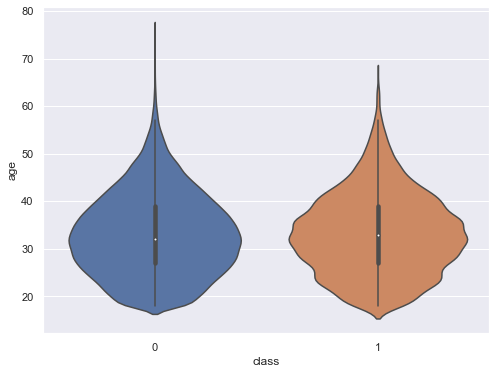

In [14]:
sns.violinplot(x='class',y='age',data=data2)

*** device_id

- each user ID is unique, but the device ID is not which means some device has been used more than once
- create a new column device_id2, if the device has been used more than once then the device_id2 is 1, otherwise is 0
- more than half of the transactions are fraudulent transactions if the device ahs been used more than once

unique user_id:  120000
unique device_id:  110599


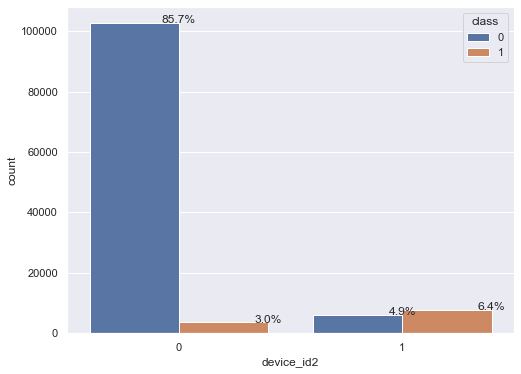

In [15]:
print('unique user_id: ',data2['user_id'].nunique())
print('unique device_id: ', data2['device_id'].nunique())

#create new column
data2['device_id2'] = np.where(data2['device_id'].duplicated(keep=False)==True, 1,0)
#plot
ax=sns.countplot(x='device_id2', hue="class",data=data2)
plot_percentage(ax, data2)

*** source

- Higher proportion of fraudulent transactions from direct sources

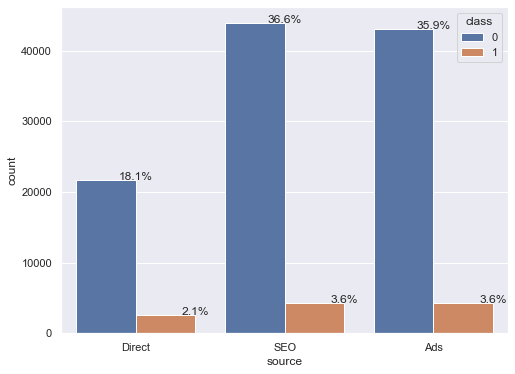

In [16]:
ax=sns.countplot(x='source', hue="class",data=data2)
plot_percentage(ax, data2)

*** country

- Use the percentage of fraudulent transactions to classify countries into 5 categories

In [17]:
# create new dataset containing the percentage of fraudulent transactions in each country
df1 = data2.groupby(['class','country']).size().reset_index().rename(columns={0:'COUNT'})
df1 = df1.pivot(index='country', columns='class', values='COUNT')
df1=df1.fillna(0)
df1['percent']=df1[1]/(df1[1]+df1[0])
df2 = df1.sort_values('percent', ascending=False)
df2[:20]

class,0,1,percent
country,,,
Turkmenistan,0.0,1.0,1.000000
Virgin Islands (U.S.),1.0,1.0,0.500000
Namibia,12.0,8.0,0.400000
Luxembourg,34.0,22.0,0.392857
Sri Lanka,14.0,8.0,0.363636
Peru,67.0,27.0,0.287234
Ecuador,64.0,23.0,0.264368
Tunisia,66.0,23.0,0.258427
Bolivia,35.0,11.0,0.239130


In [18]:
# create country class column
df2['country_class'] = np.where(
    df2['percent']>=0.2, 'A', np.where(
    df2['percent']>=0.1,'B',np.where(
        df2['percent']>0,'C','D'))) 
df3=df2.reset_index()
df3=df3[['country','country_class']]

#merge with data2
data3=data2.merge(df3, on='country', how='left')

#Classify missing values into a new class - E
data3['country_class']=data3['country_class'].fillna('E') 

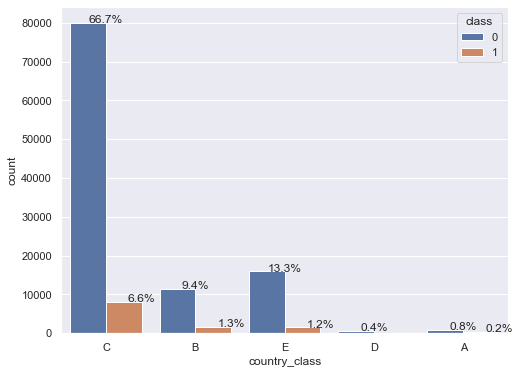

In [19]:
ax = sns.countplot(x='country_class', hue="class",data=data3)
plot_percentage(ax, data2)

## correlation

- fraudulent transactions highly correlated with same_time, device_id2
- there are some features highly correlated and will be dropped

In [103]:
# drop some columns
data4 = data3.drop(['Unnamed: 0','user_id', 'signup_time', 'purchase_time','gap_minutes',
                  'device_id','ip_address', 'country','gap_date'], axis=1)

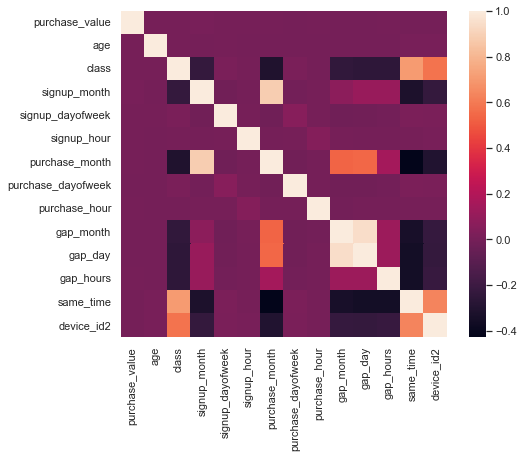

In [99]:
# correlation
f, ax = plt.subplots(figsize=(8, 6))
corr = data4.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),  square=True, ax=ax)

In [104]:
# drop some columns
data4 = data4.drop(['gap_day', 'gap_hours','signup_month','signup_hour','signup_dayofweek'], axis=1)

In [105]:
data4.head()

,purchase_value,source,browser,sex,age,class,purchase_month,purchase_dayofweek,purchase_hour,gap_month,same_time,device_id2,country_class
0,31,Direct,Chrome,M,49,0,9,3,14,2,0,1,C
1,31,SEO,IE,F,21,0,4,0,4,3,0,0,B
2,16,Direct,IE,M,26,0,4,6,12,1,0,0,C
3,29,SEO,Chrome,M,34,0,1,4,10,0,0,0,C
4,26,Ads,FireFox,M,33,0,4,3,14,2,0,0,C


# data preprocessing

- encode categorical columns

In [106]:
# encode
data4['sex']=np.where(data4['sex']=='F',1,0)
source = pd.get_dummies(data4.source, prefix='source')
browser = pd.get_dummies(data4.browser, prefix='browser')
country_class = pd.get_dummies(data4.country_class, prefix='country_class')

data5 = pd.concat([data4,source,browser,country_class], axis=1)
data6 = data5.drop(['source','browser','country_class'], axis=1)

- spliting dataset

In [107]:
from sklearn.model_selection import train_test_split
#split dataset into two part: train and test
X_train, X_test, y_train, y_test = train_test_split(data6.drop(['class'], axis=1),
                                                   data6['class'],
                                                   test_size=0.2,
                                                   random_state=0)
X_train.shape, X_test.shape

((96000, 22), (24000, 22))

- scaling

In [108]:
from sklearn.preprocessing import StandardScaler
# saclling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# model

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve

## Logistic Regression

In [110]:
logreg=LogisticRegression(max_iter=1000)
logreg_param= {'C': [0.001,0.1,1,10,40,50,100],'penalty': ['l2']}

logreg_grid = GridSearchCV(logreg, logreg_param,cv=5, return_train_score=True, scoring = 'roc_auc' )
logreg_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {logreg_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {logreg_grid.best_params_}')
print(f'Train score is {logreg_grid.score(X_train,y_train)}')
print(f'Test score is {logreg_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8318590420116287
Best Mean Cross Validation Score is {'C': 0.1, 'penalty': 'l2'}
Train score is 0.8353418802028695
Test score is 0.8320788102526049


## xgboost

In [112]:
xgbc= XGBClassifier(random_state=42,early_stopping_rounds=2,objective= 'binary:logistic')
xgbc_param = {
              'max_depth' : [2,3,4],
              'n_estimators' : [23,25],
              'learning_rate' : [0.6,0.7],
               'min_child_weight' : [3,4],
                'subsample':[0.6,0.7]
             }
xgbc = GridSearchCV(xgbc, xgbc_param,cv=5, return_train_score=True,scoring = 'roc_auc')
xgbc.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {xgbc.best_score_}')
print(f'Best Mean Cross Validation Score is {xgbc.best_params_}')
print(f'Train score is {xgbc.score(X_train,y_train)}')
print(f'Test score is {xgbc.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8305717053924292
Best Mean Cross Validation Score is {'learning_rate': 0.7, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 25, 'subsample': 0.6}
Train score is 0.8419434573593858
Test score is 0.8323581688504726


## oversampling + Logistic

In [114]:
pipe_log = Pipeline_imb([('smote',SMOTE()),
                             ('log',LogisticRegression(max_iter=1000))])
param_log = {'log__C': [0.001,0.1,1,10,40,50,100],
             'log__penalty': ['l2']}

ogrid_slog= GridSearchCV(pipe_log,param_log, cv=5, n_jobs=2,scoring = 'roc_auc')
ogrid_slog.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_slog.best_params_))
print("Best Mean cross-validation score: {:.5f}".format(ogrid_slog.best_score_))
print(f'Train score is {ogrid_slog.score(X_train,y_train)}')
print(f'test score is {ogrid_slog.score(X_test,y_test)}')

Best parameters: {'log__C': 1, 'log__penalty': 'l2'}
Best Mean cross-validation score: 0.83146
Train score is 0.8360907223142906
test score is 0.8316520513895308


## undersampling + Logistic

In [116]:
pipe_log = Pipeline_imb([('under',RandomUnderSampler(sampling_strategy=0.5)),
                             ('log',LogisticRegression(max_iter=1000))])
param_log = {'log__C': [0.001,0.1,1,10,40,50,100],
             'log__penalty': ['l2']}

ogrid_log= GridSearchCV(pipe_log,param_log, cv=5, n_jobs=2,scoring = 'roc_auc')
ogrid_log.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_log.best_params_))
print("Best Mean cross-validation score: {:.5f}".format(ogrid_log.best_score_))
print(f'Train score is {ogrid_log.score(X_train,y_train)}')
print(f'test score is {ogrid_log.score(X_test,y_test)}')

Best parameters: {'log__C': 10, 'log__penalty': 'l2'}
Best Mean cross-validation score: 0.83124
Train score is 0.8360210438194955
test score is 0.8302855115671163


## undersampling + xgboost

In [120]:
pipe_roc_xgb = Pipeline_imb([('under',RandomUnderSampler(sampling_strategy=0.5)),
                             ('xgb',XGBClassifier(random_state=42,
                                                                            objective ='binary:logistic',
                                                                            max_depth = 5,
                                                                            booster='dart'
                                                                             ))])
param_xgb = {'xgb__learning_rate' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7],
             }

ogrid_xgb= GridSearchCV(pipe_roc_xgb,param_xgb, cv=5, n_jobs=2,scoring = 'roc_auc')
ogrid_xgb.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_xgb.best_params_))
print("Best Mean cross-validation score: {:.5f}".format(ogrid_xgb.best_score_))
print(f'Train score is {ogrid_xgb.score(X_train,y_train)}')
print(f'test score is {ogrid_xgb.score(X_test,y_test)}')

Best parameters: {'xgb__learning_rate': 0.3}
Best Mean cross-validation score: 0.82695
Train score is 0.907267062187574
test score is 0.8295617650751459


## undersampling + random forest

In [118]:
pipe_roc_rfc = Pipeline_imb([('under',RandomUnderSampler(sampling_strategy=0.5)),
                             ('rfc',RandomForestClassifier(random_state=42))])
param_rfc = {'rfc__max_depth' : [2,4,6],
             'rfc__n_estimators': [200,400,500],
             'rfc__max_features':['auto', 'sqrt', 'log2']
             }

ogrid_rfc= GridSearchCV(pipe_roc_rfc,param_rfc, cv=5, n_jobs=2,scoring = 'roc_auc')
ogrid_rfc.fit(X_train, y_train)

print("Best parameters: {}".format(ogrid_rfc.best_params_))
print("Best Mean cross-validation score: {:.5f}".format(ogrid_rfc.best_score_))
print(f'Train score is {ogrid_rfc.score(X_train,y_train)}')
print(f'test score is {ogrid_rfc.score(X_test,y_test)}')

Best parameters: {'rfc__max_depth': 6, 'rfc__max_features': 'auto', 'rfc__n_estimators': 200}
Best Mean cross-validation score: 0.83156
Train score is 0.8541732779106824
test score is 0.8303902278079746


# MVP

- model: undersampling + random forest
- It based on precision and recall since it is an imbalanced dataset
- Even though it cost 8 dollar if incorrectly flag a real transaction as fraudulent and the lowest transction is 9 dollar. It seems False negative is more important than False positive, but this may lead to user loss if the real transaction is incorrectly marked as a fraudulent transaction because it will cause a very poor user purchase experience. 
- Therefore, I think both recall and precision are important in this case. In the next step, it is still better to check with the marketing team.
- And we can try to add some new features if possible. For example: products purchased (the fraudulent transaction usually happened when buying gift card), shipping location (whether it same as IP location). 

In [122]:
print("Best parameters: {}".format(ogrid_rfc.best_params_))
print("Best Mean cross-validation score: {:.5f}".format(ogrid_rfc.best_score_))
print(f'Train score is {ogrid_rfc.score(X_train,y_train)}')
print(f'test score is {ogrid_rfc.score(X_test,y_test)}', '\n')

X_test_preds = ogrid_rfc.predict(X_test)
print(classification_report(y_test, X_test_preds))

confusion = metrics.confusion_matrix(y_test, X_test_preds)
print(f"confusion matrix:\n{confusion}")

Best parameters: {'rfc__max_depth': 6, 'rfc__max_features': 'auto', 'rfc__n_estimators': 200}
Best Mean cross-validation score: 0.83156
Train score is 0.8541732779106824
test score is 0.8303902278079746 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     21739
           1       0.86      0.58      0.69      2261

    accuracy                           0.95     24000
   macro avg       0.91      0.79      0.83     24000
weighted avg       0.95      0.95      0.95     24000

confusion matrix:
[[21517   222]
 [  949  1312]]


# feature importance

- provide by random forest model
- the most important features are same_time, purchase_month, device_id2, gap_month
- similar to what we found in the correlation

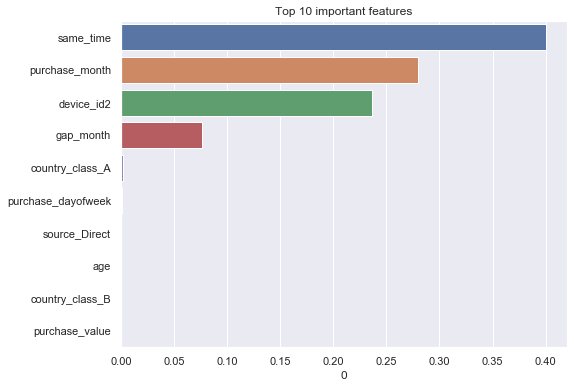

In [123]:
rf = RandomForestClassifier(random_state=42, n_estimators=500, max_features='auto',max_depth=4 )
rf.fit(X_train, y_train)

# top important features
data7=data6.drop(['class',], axis=1)

feat_importances = pd.Series(rf.feature_importances_, index=data7.columns)
feat_importances=feat_importances.nlargest(10)
cc=pd.DataFrame(feat_importances).sort_values(by=[0], ascending=False)

sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(cc[0],cc.index)
plt.title("Top 10 important features")
plt.show()